In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'

dataset_name = 'Lynx and Hare'

df = pd.read_csv(f'{data_dir}/Lynx_Hare/data.csv')
df.drop(columns = ['DATE'], inplace = True)
df = (df - df.mean()) / df.std()

train_percent = 80
train_len = int(len(df) * (train_percent / 100))
train = df.head(train_len)
test = df.tail(len(df) - train_len)

print(len(train), len(test))

72 19


The general autoregressive models is:

$$AR(X_t) = \sum_{i = 0}^p \phi_i X_{t - i} + \epsilon$$

Where the $\phi_i$ are the learned parameters and $\epsilon$ is noise. For forcasting, we remove the $\epsilon$ and treat the output as the expected value at the next timestep.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as parameterize

from torcheval.metrics.functional import r2_score

class ARModel(nn.Module):

    def __init__(self, lag):
        super().__init__()

        # The basic autoregressive model is simply a linear combination of the last values
        self.output = nn.Linear(lag, 1)
        self.lag = lag

    def forward(self, input):
        return self.output(input)
    
    def fit(self, data, test = None, iters = 200, lr = 0.001, verbose = False):
        self.mse = { 'train' : [], 'test' : [] }
        self.r2 = { 'train' : [], 'test' : [] }
        self.MAE = { 'train' : [], 'test' : [] }
        
        # We will use 100 iterations of stochastic gradient descent with a learning rate
        # of 0.001
        optimizer = optim.Adam(self.parameters(), lr = lr)

        # Mean Square Error loss
        loss_fn = nn.MSELoss()

        # First generate the sequences of inputs and outputs in the proper tensor format
        input, output = [], []
        for i in range(self.lag, len(data)):
            input.append(torch.tensor(data[i - self.lag:i], dtype = torch.float32))
            output.append(torch.tensor([data[i]], dtype = torch.float32))

        if test is not None:
            test_input, test_output = [], []
            for i in range(self.lag, len(test)):
                test_input.append(torch.tensor(test[i - self.lag:i], dtype = torch.float32))
                test_output.append(torch.tensor([test[i]], dtype = torch.float32))

        for _ in range(iters):
            predicted = []
            total_loss = 0
            for x, y in zip(input, output):
                # We need to zero the gradients for each optimization step
                optimizer.zero_grad()

                # Calculate the loss for this step
                pred = self.forward(x)
                loss = loss_fn(pred, y)
                total_loss += loss
                predicted.append(pred)

                # Backpropagate the loss
                loss.backward()

                # Step the optimizer forward to update the parameters
                optimizer.step()
            if verbose: print(f'total loss: {total_loss:.4f}')

            self.mse['train'].append(
                nn.functional.mse_loss(torch.tensor(predicted), torch.tensor(output))
            )

            self.r2['train'].append(
                r2_score(torch.tensor(predicted), torch.tensor(output))
            )

            self.MAE['train'].append(
                nn.functional.l1_loss(torch.tensor(predicted), torch.tensor(output))
            )

            if test is not None:
                predicted = []
                for x, y in zip(test_input, test_output):
                    pred = self.forward(x)
                    predicted.append(pred)
                
                self.mse['test'].append(
                    nn.functional.mse_loss(torch.tensor(predicted), torch.tensor(test_output))
                )

                self.r2['test'].append(
                    r2_score(torch.tensor(predicted), torch.tensor(test_output))
                )

                self.MAE['test'].append(
                    nn.functional.l1_loss(torch.tensor(predicted), torch.tensor(test_output))
                )



In [4]:
species = []

# Determine the species in this dataset
for c in df.columns:
    species.append(c)  

# The lag for the AR Models, this is the number of previous instances
# that are used for each predictions
lag = 2

# We have an independent model for each species
model = { s : ARModel(lag) for s in species }

for s in species:
    data = train[s].tolist()
    test_data = test[s].tolist()
    model[s].fit(data, test = test_data, iters = 200, verbose = False)



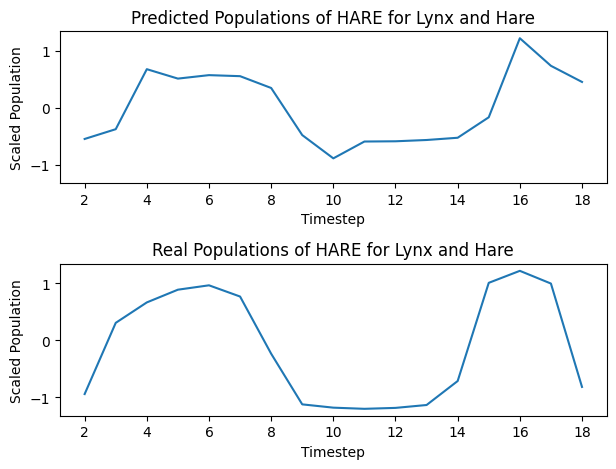

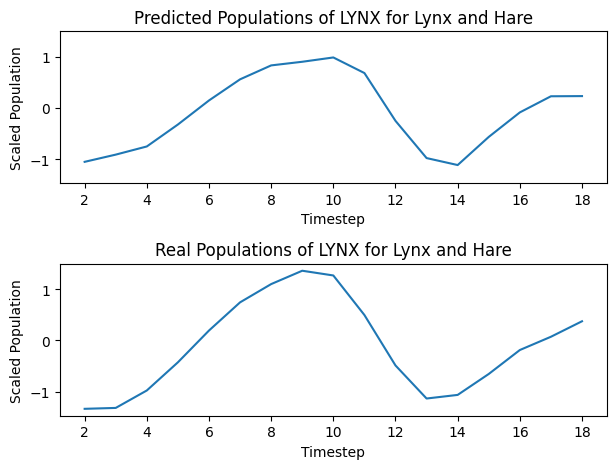

MSE: 0.4018
R2: 0.7689
MAE: 0.6843


In [5]:
from torcheval.metrics.functional import r2_score

x = [i for i in range(lag, len(test))]

data = { s : test[s].tolist() for s in species }

mse_loss = 0
l1_loss = 0
r2_loss = 0

for s in species:
    fig, (predicted, real) = plt.subplots(2, sharey = True)

    predictions, expected = [], []
    for i in range(lag, len(test)):
        input = torch.tensor(data[s][i - lag:i], dtype = torch.float32)
        expected.append(data[s][i])
        predictions.append(model[s].forward(input).item())
    
    mse_loss += nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(expected))
    l1_loss += nn.functional.l1_loss(torch.tensor(predictions), torch.tensor(expected))
    r2_loss += r2_score(torch.tensor(predictions), torch.tensor(expected)) / len(species)
    
    predicted.plot(x, predictions)
    predicted.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    predicted.set_xlabel('Timestep')
    predicted.set_ylabel('Scaled Population')
    real.plot(x, expected)
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()

print(f'MSE: {mse_loss:.4f}')
print(f'R2: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

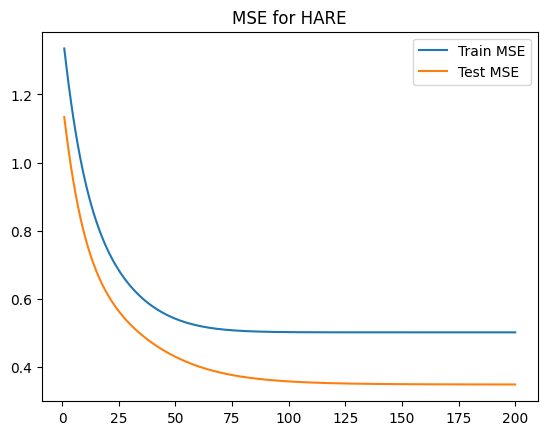

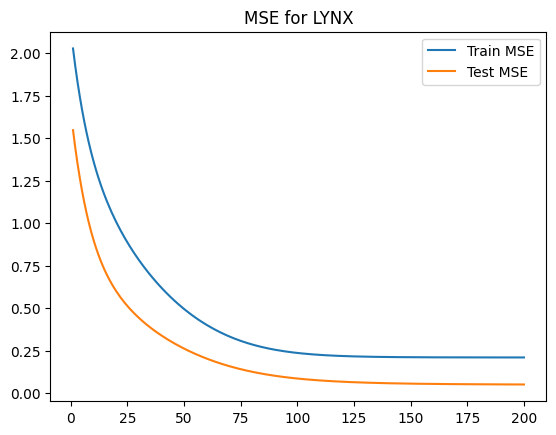

In [6]:
for s in species:
    plt.plot(range(1, 201), model[s].mse['train'], label = 'Train MSE')
    plt.plot(range(1, 201), model[s].mse['test'], label = 'Test MSE')
    plt.title(f'MSE for {s}')
    plt.legend()
    plt.show()

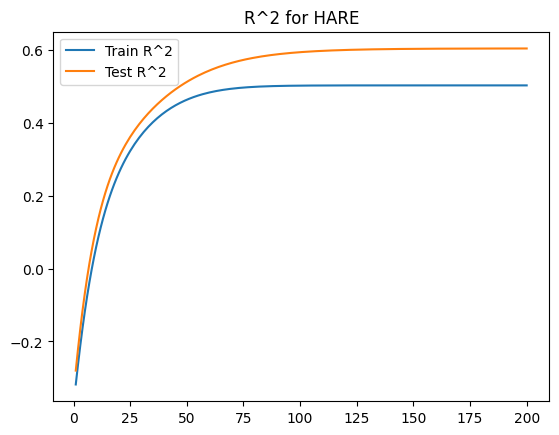

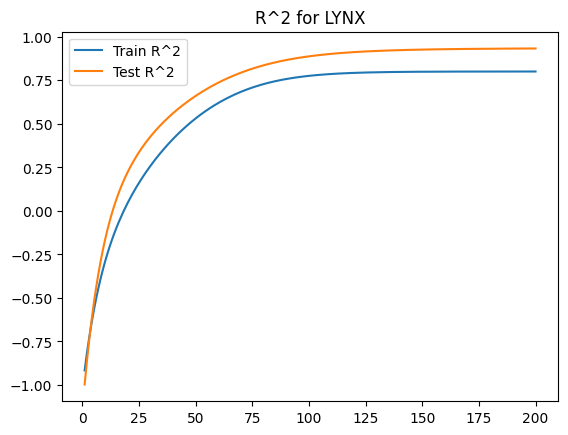

In [7]:
for s in species:
    plt.plot(range(1, 201), model[s].r2['train'], label = 'Train R^2')
    plt.plot(range(1, 201), model[s].r2['test'], label = 'Test R^2')
    plt.title(f'R^2 for {s}')
    plt.legend()
    plt.show()

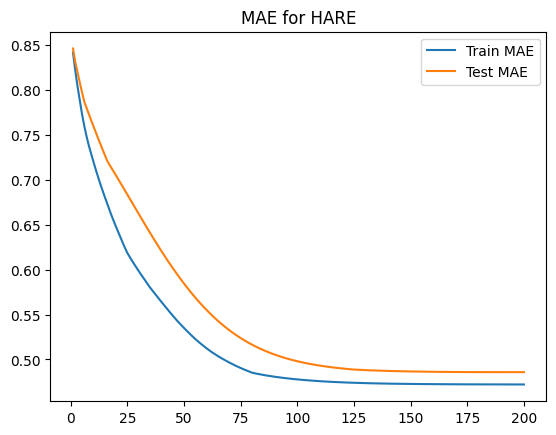

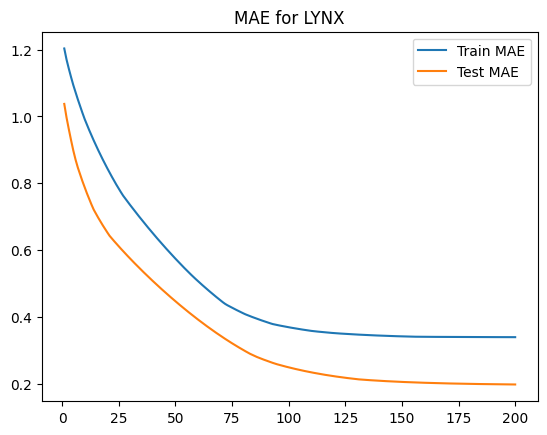

In [8]:
for s in species:
    plt.plot(range(1, 201), model[s].MAE['train'], label = 'Train MAE')
    plt.plot(range(1, 201), model[s].MAE['test'], label = 'Test MAE')
    plt.title(f'MAE for {s}')
    plt.legend()
    plt.show()